**Title:** Simulation of Upper Limb Motion With and Without Tremor in Time and Frequency Domains

**Description:** This code simulates and analyzes the motion of an upper limb affected by tremor, specifically modeled as resting tremor characteristic of Parkinson's disease. The simulation includes both time-domain and frequency-domain representations for comparison between normal and tremor-affected movements.

**Tremor Model:** Resting tremor – Parkinson’s Disease

**Authors:** Gabriel B. Albuquerque, Marcela R. Machado

Affiliation: **bold text**University of Brasília (UnB)

**Code Version:** V1

Programa de Computador- Número do registro: BR512023002953-0

**Validation Method:** Based on literature data and clinical tremor characteristics.

**Reference model:** ALBUQUERQUE, G. G. S. B. ; R. MACHADO, MARCELA . Design of Passive Dynamic Absorbers to Attenuate Pathological Tremor of Human Upper Limb. Lecture Notes in Mechanical Engineering. 1ed.: Springer Nature Switzerland, 2025, v. , p. 271-285.


Projeto financiado pela FAPDF no. 435/2023 Processo nº00193-00002143/2023-02, CHAMADA PÚBLICA 01/2023 BIO LEARNING / VINCULADA AO EDITAL 10/2023 - PROGRAMA FAPDF LEARNING Programa de Fomento Estratégico na macro área da linha de pesquisa: BIO Learning.


In [ ]:
from scipy.integrate import odeint
from matplotlib import pyplot as plt
from math import atan2,asin,pi,log10,cos,sin
from IPython.core.display import update_display
import numpy as np
import numpy.linalg as np_la
import math as mt
import scipy.linalg as sp_la
import cmath as cm
import sympy as sy
import time
from scipy.fft import *
from google.colab import files
import numba

Primary system

In [ ]:
n_ps=3            #DOF of the primary system

l1=0.364;      #upper arm
l2=0.299;      #forearm
l3=0.203;      #hand

a1=0.427*l1;   #centroid upper arm
a2=0.417*l2;   #centroid forearm
a3=0.361*l3;   #centroid palm

m1=2.07;       #upper arm
m2=1.16;       #forearm
m3=0.54;       #hand

I1=0.0228;     #Moment of inertia upper arm
I2=0.0082;     #Moment of inertia forearm
I3=0.0012;     #Moment of inertia palm

K1=180;        #muscle shoulder
K2=70;         #muscle elbow
K3=40;         #muscle biceps
K4=10;         #muscle wrist

C1=0.002*K1;   #muscle shoulder
C2=0.002*K2;   #muscle elbow
C3=0.002*K3;   #muscle biceps
C4=0.001*K4;   #muscle wrist

In [ ]:
#Building the matrix of mass of the primary system

#Each term will be calculated separately

M11 = (I1+m1*a1**2)+(I2+m2*a2**2)+m2*l1**2 + I3 + m3*(l1**2+l2**2+a3**2+2*l2*a3);
M12 = (I2+m2*a2**2) + I3 + m3*(l2**2+a3**2+2*l2*a3);
M13 = I3 + m3*(a3**2+l2*a3);

M21 = M12;
M22 = M12;
M23 = M13;

M31 = M13;
M32 = M13;
M33 = I3+m3*a3**2;

#The mass matrix of the primary system

M_ps=np.array([[M11,  M12,  M13],
               [M21,  M22,  M23],
               [M31,  M32,  M33]]);

#The stiffness matrix of the primary system

K_ps=np.array([[K1+K3,   K3,    0],
               [K3,   K2+K3,    0],
               [0,      0,     K4]])

#The damping matrix of the primary system

C_ps=np.array([[C1+C3,   C3,    0],
               [C3,   C2+C3,    0],
               [0,      0,     C4]])

In [ ]:
#Calculating the eigenvalues (Wn)  and the eigenvectors (U)

[natu_freq_ps,mod_ps] = sp_la.eigh(K_ps,M_ps);

#Building the natural frequencies matrix ---------------------------------------

natu_freq_ps_diag = np.sqrt(np.diag(abs(natu_freq_ps))); #matrix diag

natu_freq_ps_vec = np.sort(np.sqrt(abs(natu_freq_ps))) #vector

#Printing in sequence

for i in range(1,n_ps+1):
    freq_n='Wn_NUMERO='
    freq_n=freq_n.replace("NUMERO", str(i))
    ordem_natu_freq_ps=np.diag(natu_freq_ps_vec)
    print(freq_n,round(ordem_natu_freq_ps[i-1,i-1]/(2*np.pi),5), 'Hz')

print('-----------------------------------------------------------------------')

#Building the modal matrix -----------------------------------------------------

Meffs = mod_ps.transpose() @ M_ps @ mod_ps

mod_ps_norm = mod_ps @ np.diag(1/np.sqrt(np.diag(Meffs)))

for i in range(0,n_ps):
    modo='Un='
    modo_n=modo.replace("n", str(i+1))
    print(modo_n,mod_ps_norm[:,i])

Wn_1= 3.58803 Hz
Wn_2= 5.30097 Hz
Wn_3= 14.34746 Hz
-----------------------------------------------------------------------
U1= [1.32026211 0.5378803  1.90069146]
U2= [-1.26178455  2.71542741  4.7128258 ]
U3= [ 0.14124352 -4.52410607 24.33499214]


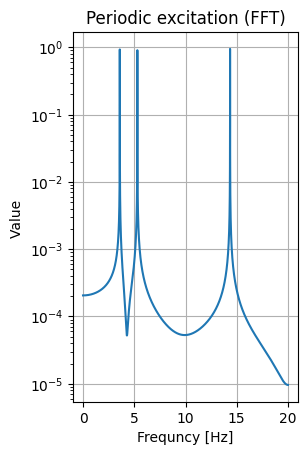

In [ ]:
df = 0.001;  #Heigth of each step
fi = 0;       #Where it was started
ff = 20;     #Half sampling frequency
fs = 2*ff;   #Sampling frequency

freq = np.arange(fi,ff+df,df)  #Frequency vector
omega = freq*2*pi;            #Circular frequency

N = len(omega);               #The number of items in circular frequency

dt = 1/fs; #rate time

t = np.arange(0,dt*(2*N),dt); #Time range

#Force definition
#3.569 5.300 12.566
freqExc = ordem_natu_freq_ps[0,0]; #The first natural frequency of the primary system
freqExc2 = ordem_natu_freq_ps[1,1];#The second natural frequency of the primary system
freqExc3 = ordem_natu_freq_ps[2,2];#The third natural frequency of the primary system

AMp=1; #Amplitude

f0 = AMp*np.cos(freqExc*t)+ AMp*np.cos(freqExc2*t) + AMp*np.cos(freqExc3*t)#Considering the muscle activity of shoulder's muscle and elbow's muscles

F0 =(1/N)*fft(f0)  #FFT of force vector
#print(F0)

#Plotting the Force's graph
plt.subplot(1,2,2)
plt.semilogy(freq,abs(F0[0:N]))
plt.title('Periodic excitation (FFT)')
plt.xlabel('Frequncy [Hz]')
plt.ylabel('Value ')
plt.grid()
plt.show()

**Frequency domain response**

Primary System

<ipython-input-9-4e3be9f36edb>:14: ComplexWarning: Casting complex values to real discards the imaginary part
  F_ps[len(F_ps)-4] = F0[ii];                          #Excitation from shoulder muscle
<ipython-input-9-4e3be9f36edb>:15: ComplexWarning: Casting complex values to real discards the imaginary part
  F_ps[len(F_ps)-3] = F0[ii];                          #Excitation from elbow muscle
<ipython-input-9-4e3be9f36edb>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  F_ps[len(F_ps)-2] = F0[ii];                          #Excitation from elbow muscle


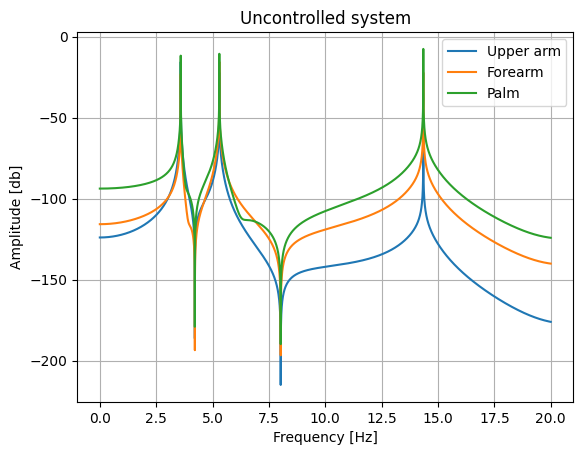

In [ ]:
#The primary system's response to the excitation stemming from the muscualar activity of shoulder and elbow muscles

Yf_ps=np.zeros((n_ps,N))  #Making the matrix of the vibration's mode
F_ps=np.zeros((n_ps,1))   #Making the matrix of the forcing

#Defining the imaginary part
real = 0
img = 1
i = complex(real,img)

#Calculating the vibration's amplitude
for ii in range(0,N):
    w2 = omega[ii];                                      #Frequency range
    F_ps[len(F_ps)-4] = F0[ii];                          #Excitation from shoulder muscle
    F_ps[len(F_ps)-3] = F0[ii];                          #Excitation from elbow muscle
    F_ps[len(F_ps)-2] = F0[ii];                          #Excitation from elbow muscle
    D_ps = K_ps-w2**2*M_ps-(i*w2*C_ps);                  #Matrix of dynamic stiffness
    Yf_ps[:,ii] = abs(np.transpose(np_la.pinv(D_ps) @ F_ps)); #Displacement in frequency domain

#Plotting graphs
plt.plot(freq,20*np.log10(abs(Yf_ps[0,:])),label='Upper arm')
plt.plot(freq,20*np.log10(abs(Yf_ps[1,:])),label='Forearm')
plt.plot(freq,20*np.log10(abs(Yf_ps[2,:])),label='Palm')
plt.legend()
plt.title('Uncontrolled system')
plt.ylabel('Amplitude [db]')
plt.xlabel('Frequency [Hz]')
plt.grid()
plt.show()

<ipython-input-11-874bf203b1c5>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return [float(i) for i in dydt]    #The displacement vector


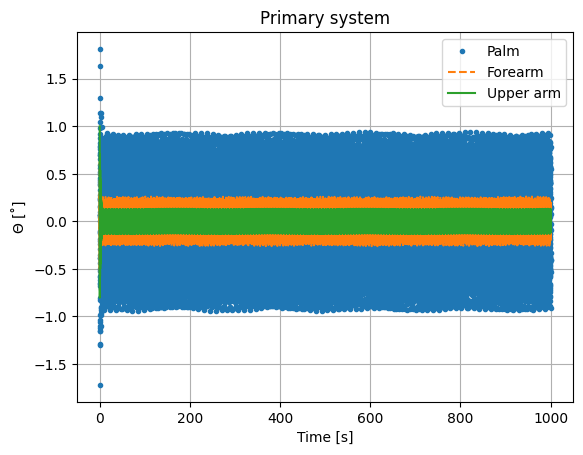

In [ ]:
#Integral function

def fngdl(y,t):
    Y_ps = np.array([[y[i]] for i in range(len(y))]) #Initial conditions

    F_apl= np.array([[np.cos(freqExc*t)], #Shoulder's muscle excitation
                     [np.cos(freqExc2*t)], #Elbow's muscle excitation
                     [np.cos(freqExc3*t)]])#Wrist's muscle excitation

    dydt = A_ps @ Y_ps + B_ps @ F_apl #The speed vector

    return [float(i) for i in dydt]    #The displacement vector


M_nu_ps=np.zeros((n_ps,n_ps)) #Zero matrix
M_ind_ps=np.identity(n_ps)    #Identity matrix
inv_M_ps=sp_la.inv(M_ps)      #Inverse of the mass matrix

#Building the matrix A ---------------------------------

mk_ps=-inv_M_ps @ K_ps #Stifness part
mc_ps=-inv_M_ps @ C_ps #Damping part

pc=np.concatenate((M_nu_ps,M_ind_ps),axis=1) #The upper part
pb=np.concatenate((mk_ps,mc_ps),axis=1)      #The lower part

A_ps=np.concatenate((pc,pb),axis=0) #Matrix A

#Calculating the matrix B ---------------------------------

B_ps=np.concatenate((M_nu_ps,inv_M_ps),axis=0) #Matrix B

#Initial conditions

u01=1 #m
v01=0 #m/s
u02=0 #m
v02=0 #m/s
u03=0 #m
v03=0 #m/s

u0_n_ps=[u01,u02,u03,v01,v02,v03] #List of initial conditions

#Calculating the response in time domain

ut_wab_ps=odeint(fngdl, u0_n_ps, t) #The response of the primary system

#Ploting graphs
plt.figure()
plt.plot(t, ut_wab_ps[:,2],'.',label='Palm')
plt.plot(t, ut_wab_ps[:,1],'--',label='Forearm')
plt.plot(t, ut_wab_ps[:,0],label='Upper arm')
plt.title('Primary system')
plt.ylabel('$\Theta$ [˚]')
plt.xlabel('Time [s]')
plt.legend()
plt.grid()
plt.show()